In [1]:
%matplotlib inline
import networkx
import obonet
import goenrich
import pandas as pd 
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import textwrap
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
gene2go = goenrich.read.gene2go('../../../go_db/gene2go',tax_id=3702)
annot   = pd.read_csv('../../../go_db/Arabidopsis_thaliana.gene_info',sep='\t')
graph = obonet.read_obo('../../../go_db/go-basic.obo')

print (networkx.info(graph))

ATID     = annot['LocusTag']
GENEID   = annot['GeneID']
dicAT2GD = dict(zip(ATID,GENEID))
dicGD2AT = dict(zip(GENEID,ATID))

sub_genelist = [x.strip() for x in open('../genelist.txt').readlines()]
sub_genelist_geneid = [dicAT2GD[x] for x in sub_genelist]

print('total number of query genes : %d'%len(set(sub_genelist)))
print('total number of query geneids : %d '%len(set(sub_genelist_geneid)))

id_to_name = {id_: data['name'] for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True)}
gene2go_ix = gene2go.set_index('GeneID')

Name: go
Type: MultiDiGraph
Number of nodes: 44540
Number of edges: 92645
Average in degree:   2.0800
Average out degree:   2.0800
total number of query genes : 161
total number of query geneids : 161 


In [23]:
# sub GO from query gene list
# GO enrichment using fisher
sub_gene2go = gene2go_ix.loc[sub_genelist_geneid]

target_GO = set(sub_gene2go.dropna()['GO_ID'].values)

dicGO2P = {'GO':[],
           'Odds':[],
           'Pvalue':[]
          }
for GO in target_GO:
    x = list(sub_gene2go['GO_ID'].values).count(GO)
    X = len(sub_gene2go['GO_ID'].values) 
    n = list(gene2go['GO_ID'].values).count(GO)
    N = len(gene2go['GO_ID'].values)
    o,p = fisher_exact([[x,n],[X-x,N-n]])
    dicGO2P['GO'].append(GO)
    dicGO2P['Odds'].append(o)
    dicGO2P['Pvalue'].append(p)

df_go_enrich = pd.DataFrame(dicGO2P)   

 
df_go_enrich['def'] = df_go_enrich['GO'].apply(lambda x : graph.node[x]['def'])
df_go_enrich['name'] = df_go_enrich['GO'].apply(lambda x : graph.node[x]['name'])

df_go_enrich = df_go_enrich[['GO','Pvalue','Odds','name','def']]
m = (df_go_enrich['Odds'] > 1) & (df_go_enrich['Pvalue'] < 0.01) 
df_go_enrich[m].to_excel('GO_enrichment_table.xls')

In [16]:
# sig GO and corresponding gene retrieve 
dicGO2P    = dict(zip(df_go_enrich['GO'],df_go_enrich['Pvalue']))
m          = df_go_enrich['Pvalue'] < 0.01
sig_GO     = set(df_go_enrich[m]['GO'].values)
sig_GeneID = list(set(sub_gene2go.reset_index().set_index('GO_ID').loc[sig_GO]['GeneID'].values))

annot_ix = annot.set_index('GeneID')

In [13]:
# Draw geneid-associated GOs that node-colored by GO enrichment
def draw_Gene2GO(geneid):
    sub_sig_GO = set(sub_gene2go.loc[geneid]['GO_ID'].values) & sig_GO
    dicC2Path = {'biological_process':[],
                 'molecular_function':[],
                 'cellular_component':[]
                }
    
    for e in dicC2Path.keys():
        sub_nodes = []
        for end in sub_sig_GO:
            #end = list(sub_sig_GO)[0]
            paths = networkx.all_simple_paths(
                graph,
                source=end,
                target=name_to_id[e]
            )

            for path in paths:
                sub_nodes += path
        dicC2Path[e] = sub_nodes
    
    fig,ax = plt.subplots(1,3,figsize=(25,7))
    nodes_list = []
    for ix, e in enumerate(dicC2Path.keys()):
        plt.sca(ax[ix])
        plt.axis('off')
        ax[ix].set_title(e)
        sub_nodes = dicC2Path[e]
        diclabels_sig = {x:textwrap.fill(y, width=10) for x,y  in id_to_name.items() if x in set(sub_nodes)&sig_GO }        
        diclabels_nonsig = {x:textwrap.fill(y, width=10) for x,y  in id_to_name.items() if x in set(sub_nodes)-set(sig_GO) }     
        sg = graph.subgraph(sub_nodes)
        #pos = networkx.spring_layout(sg)
        pos = graphviz_layout(sg,prog="dot")
        #pos = hierarchy_pos(sg,name_to_id[e])
        def get_p(x):
            try:
                return dicGO2P[x]
            except KeyError:
                return 1
        #colors = ['r' if get_p(x)<0.01 else 'gray' for x in sg.node.keys()]
        colors = [np.log(get_p(x)) for x in sg.node.keys()]
        nodes = networkx.draw_networkx_nodes(sg,pos=pos,node_color=colors,cmap='spring')
        networkx.draw_networkx_edges(sg,pos=pos,edge_color='gray')
        networkx.draw_networkx_labels(sg,pos=pos,labels=diclabels_sig,font_size=8,font_color='black')
        networkx.draw_networkx_labels(sg,pos=pos,labels=diclabels_nonsig,font_size=5,font_color='gray')
        nodes_list.append(nodes)

    fig.text(0.5, -0.02,"%s (%s) : %s"%(dicGD2AT[geneid],annot_ix.loc[geneid]['Symbol'],annot_ix.loc[geneid]['description']) )
    for nodes in nodes_list:
        if isinstance(nodes,mpl.collections.PathCollection):
            plt.colorbar(nodes)
    plt.tight_layout()
    plt.show()
    #plt.savefig("GOE_%s.png"%dicGD2AT[geneid],dpi=400,bbox_inches='tight')

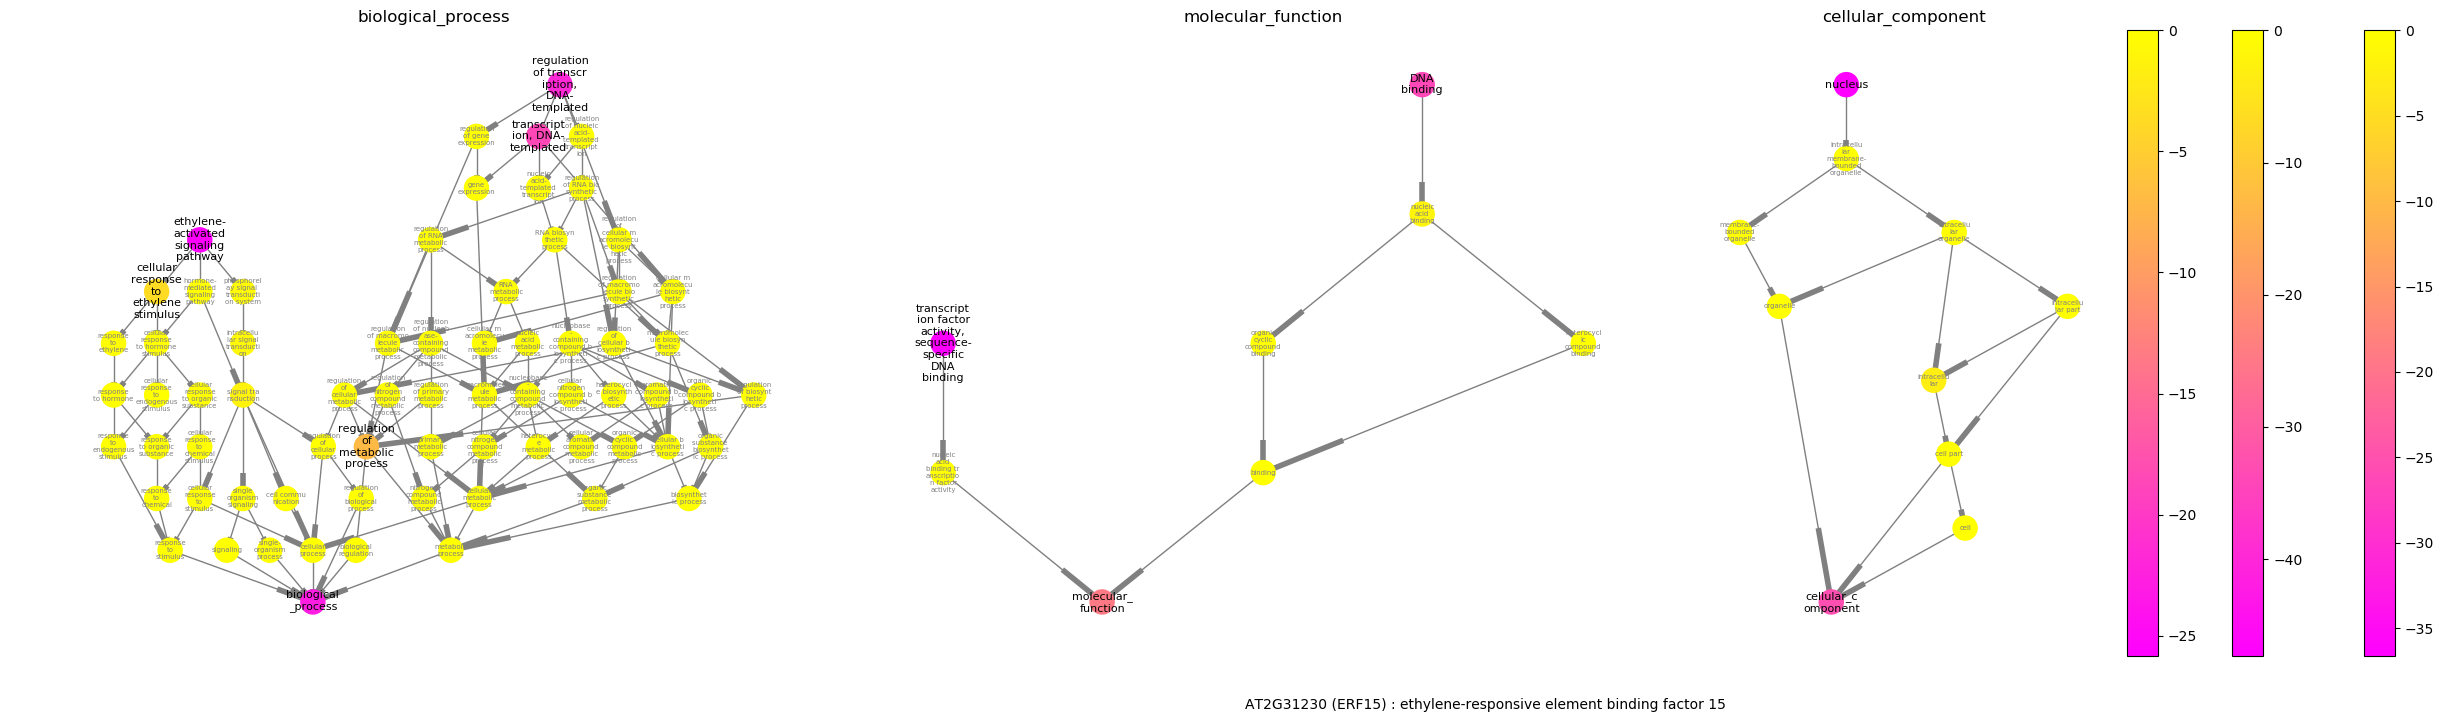

In [19]:
draw_Gene2GO(sig_GeneID[3])